
Wyniki dla modelu: Logistic Regression (Pipeline)
              precision    recall  f1-score   support

           0       0.84      0.83      0.83       105
           1       0.76      0.77      0.77        74

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179



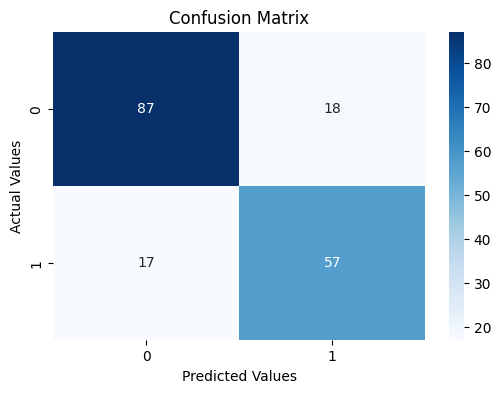

                            Model  F1_score       AUC
0  Logistic Regression (Pipeline)  0.765101  0.843887


In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Custom Transformer dla kolumny Name
class FilterName(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()
        column = self.column
        X_transformed[column] = X_transformed[column].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
        X_transformed.loc[~X_transformed[column].isin(['Mr', 'Miss', 'Mrs']), column] = 'Other'
        return X_transformed

# Wczytanie danych Titanic
data = pd.read_csv('C:/Users/mpiesio/Desktop/KODILLA/wizualizacja/titanic.csv') 

# Wybór cech i zmiennej docelowej
num_features = ['Age', 'SibSp', 'Parch', 'Fare']
cat_features = ['Name', 'Sex', 'Embarked']
X = data[num_features + cat_features]
y = data['Survived']

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline dla zmiennych numerycznych
num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean')),
    ('polynomial_features', PolynomialFeatures(degree=2)),
    ('scaler_1', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('scaler_2', StandardScaler())
])

# Pipeline dla zmiennych kategorycznych
cat_preparation = Pipeline(steps=[
    ('filter_name', FilterName(column='Name')),
    ('fill_missings', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Połączenie w ColumnTransformer
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features),
    ('categorical_preprocessing', cat_preparation, cat_features)
])

# Pipeline z modelem
model_pipeline = Pipeline(steps=[
    ('preprocessor', data_preparation),
    ('model', LogisticRegression(max_iter=10000))
])

# Trenowanie modelu
model_pipeline.fit(X_train, y_train)

# Funkcja do oceny modelu
def calculate_metrics(model, name, X_checked, y_checked):
    predictions = model.predict(X_checked)
    predictions_proba = model.predict_proba(X_checked)[:, 1]
    
    # Metryki
    print(f"\nWyniki dla modelu: {name}")
    print(classification_report(y_checked, predictions))
    
    # Macierz pomyłek
    cm = confusion_matrix(y_checked, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.show()
    
    # Metryki F1 i AUC
    f1 = f1_score(y_checked, predictions)
    auc = roc_auc_score(y_checked, predictions_proba)
    return {'Model': name, 'F1_score': f1, 'AUC': auc}

# Ocena modelu
metrics = calculate_metrics(model_pipeline, 'Logistic Regression (Pipeline)', X_test, y_test)

# Wyświetlenie metryk
metrics_df = pd.DataFrame([metrics])
print(metrics_df)